<a href="https://colab.research.google.com/github/johnnfujita/tensorflow_certificate_prep/blob/main/dnn_for_timeseries_single_layer_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5


series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l_0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l_0])

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)
print("Layer weights{}".format(l_0.get_weights()))

Layer weights[array([[-0.01473984],
       [ 0.01327908],
       [-0.06828497],
       [ 0.00587891],
       [ 0.07445447],
       [ 0.05329583],
       [-0.041001  ],
       [-0.05228669],
       [ 0.03431874],
       [-0.03805605],
       [ 0.04657792],
       [ 0.02166223],
       [-0.10423563],
       [ 0.04551996],
       [ 0.05036958],
       [ 0.05167388],
       [ 0.01066162],
       [ 0.19570109],
       [ 0.33641818],
       [ 0.36818174]], dtype=float32), array([0.01432567], dtype=float32)]


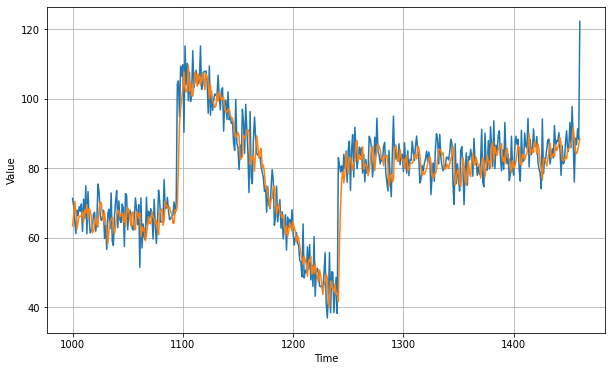

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9448385

In [1]:
# With dnn

In [7]:
model_2 = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                      tf.keras.layers.Dense(10, activation="relu"),
                                      tf.keras.layers.Dense(1)
])

model_2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model_2.fit(dataset, epochs=100, verbose=0)


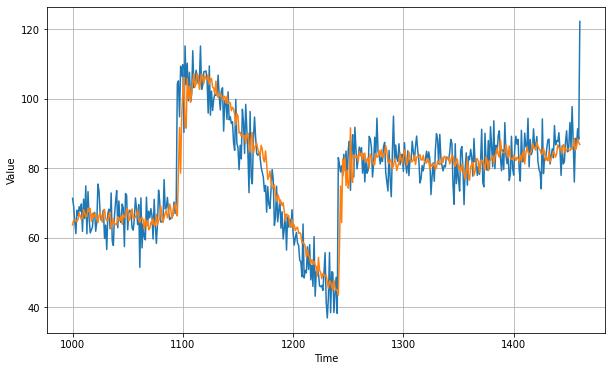

In [8]:
forecast_2 = []
for time in range(len(series) - window_size):
  forecast_2.append(model_2.predict(series[time:time + window_size][np.newaxis]))

forecast_2 = forecast_2[split_time-window_size:]
results_2 = np.array(forecast_2)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results_2)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results_2).numpy()

5.0439267

In [10]:
### WITH DNN and adjusting the learning rate

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                      tf.keras.layers.Dense(10, activation="relu"),
                                      tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

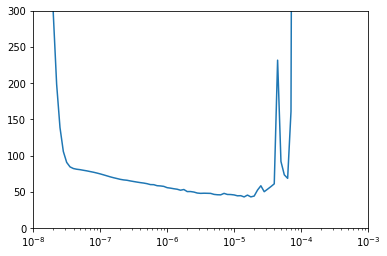

In [13]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [14]:
window_size = 30

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                      tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
                                      tf.keras.layers.Dense(10, activation="relu"),
                                      tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500,  verbose=0)


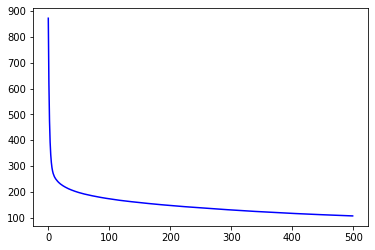

In [17]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.show()

[258.74066162109375, 254.48609924316406, 250.5488739013672, 247.3072052001953, 244.23300170898438, 241.51498413085938, 238.86093139648438, 236.45164489746094, 234.24114990234375, 232.23548889160156, 230.31187438964844, 228.57130432128906, 226.86508178710938, 225.21067810058594, 223.65745544433594, 222.1746368408203, 220.72169494628906, 219.4269561767578, 218.11599731445312, 216.8521728515625, 215.54893493652344, 214.3841552734375, 213.2136688232422, 212.0941162109375, 211.02236938476562, 210.02456665039062, 209.01121520996094, 208.07662963867188, 207.14149475097656, 206.2116241455078, 205.34188842773438, 204.45672607421875, 203.62179565429688, 202.75306701660156, 201.93186950683594, 201.10728454589844, 200.3323516845703, 199.54722595214844, 198.8177947998047, 198.07606506347656, 197.35975646972656, 196.67613220214844, 196.01622009277344, 195.32701110839844, 194.68568420410156, 194.0226287841797, 193.40342712402344, 192.7728729248047, 192.17959594726562, 191.5807647705078, 191.024475097

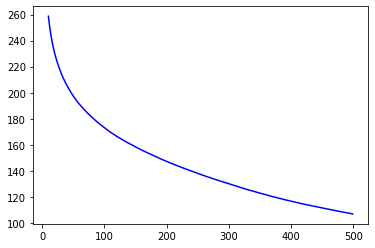

In [18]:
loss = history.history["loss"]
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, "b", label="Training Loss")
plt.show()

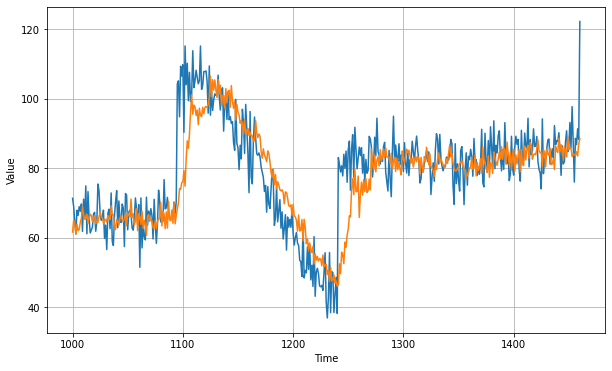

In [19]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.446041